# Reproducing de Boer's results (2000)

As a first step, we try to reproduce the results found by de Boer in his paper from 2000.
This paper will form the basis for our project thus reproducing its results is an important first step.
Thanks to de Boer being the teaching professor of the Evolution of Speech course @ VUB 2021-2022, we have access to the source code of this paper.

**Reference**: de Boer, B. (2000). Self-organization in vowel systems. *In Journal of Phonetics (Vol. 28, Issue 4, pp. 441–465)*. Elsevier BV. https://doi.org/10.1006/jpho.2000.0125

## Table of contents

- Student information
- Required imports
- Synthesizer equations
- Synthesizer classes
- Determining distances between utterances

## Student information

- **Name**: Bontinck Lennert
- **Student ID**: 568702
- **Affiliation**: VUB - Master Computer Science: AI

## Required imports

Below we import the required things for this notebook.

In [1]:
import random as rnd
import math
import matplotlib.pyplot as plt
import numpy as np

## Synthesizer equations

Bart de Boer's system consists of agents who can produce, perceive, and remember speech sounds in a human-like way.
To make this work the agents are equipped with an articulatory synthesizer.
This synthesizer takes as input the three major vowel parameters:

- tongue position: **p**
- tongue height: **h**
- lip rounding: **r**

The outputs of the synthesizer are the first four formant frequencies of the corresponding vowel.

- $F_1 (Hz)$
- $F_2 (Hz)$
- $F_3 (Hz)$
- $F_4 (Hz)$

Example input/outputs are given in table 1 of de Boer's paper (2000) and the Equations for $F_1$ to $F_4$ are given in table 1 of his paper (2000).
In the below code block we will first make the functions for each $F_x$ and check their output by comparing the values to the examples from the first table of de Boer's paper (2000).

In [2]:
# Defintions based on calculation functions from synthesise.cpp of de Boer's source code (2000)
def calculate_f1(p, h, r):
    f1 = ((-392+392*r)*pow(h, 2)+(596-668*r)*h-146+166*r)*pow(p, 2);
    f1 += ((348-348*r)*pow(h, 2)+(-494+606*r)*h+141-175*r)*p;
    f1 += ((340-72*r)*pow(h, 2)+(-796+108*r)*h+708-38*r);
    
    return f1;

def calculate_f2(p, h, r):
    f2 = ((-1200+1208*r)*pow(h, 2)+(1320-1328*r)*h+118-158*r)*pow(p, 2);
    f2 += ((1864-1488*r)*pow(h, 2)+(-2644+1510*r)*h-561+221*r)*p;
    f2 += ((-670+490*r)*pow(h, 2) + (1355-697*r)*h + 1517-117*r);
    
    return f2;

def calculate_f3(p, h, r):
    f3 = ((604-604*r)*pow(h, 2)+(1038-1178*r)*h+246+566*r)*pow(p, 2);
    f3 +=((-1150+1262*r)*pow(h, 2)+(-1443+1313*r)*h-317-483*r)*p;
    f3 +=((1130-836*r)*pow(h, 2)+(-315+44*r)*h+2427-127*r);
    
    return f3;

def calculate_f4(p, h, r):
    f4 = ((-1120+16*r)*pow(h, 2)+(1696-180*r)*h+500+522*r)*pow(p, 2);
    f4 +=((-140+240*r)*pow(h, 2)+(-578+214*r)*h-692-419*r)*p;
    f4 +=((1480-602*r)*pow(h, 2)+(-1220+289*r)*h+3678-178*r);
    
    return f4;


We now check if the above functions return the correct formant values by testing all of the values given in table 2 of de Boer (2000).

In [3]:
argument_sets = [[0, 0, 0],
                 [0, 0, 1],
                 [0.5, 0, 0],
                 [0.5, 0, 1],
                 [1, 0, 0],
                 [1, 0, 1],
                 [0, 0.5, 0],
                 [0, 0.5, 1],
                 [0.5, 0.5, 0],
                 [0.5, 0.5, 1],
                 [1, 0.5, 0],
                 [1, 0.5, 1],
                 [0, 1, 0],
                 [0, 1, 1],
                 [0.5, 1, 0],
                 [0.5, 1, 1],
                 [1, 1, 0],
                 [1, 1, 1]];

values = [[708, 1517, 2427, 3678],
          [670, 1400, 2300, 3500], 
          [742, 1266, 2330, 3457],
          [658, 1220, 2103, 3200],
          [703, 1074, 2356, 3486],
          [656, 1020, 2312, 3411],
          [395, 2027, 2552, 3438],
          [393, 1684, 2238, 3254],
          [399, 1438, 2118, 3197],
          [400, 1267, 2005, 2996],
          [430, 1088, 2142, 3490],
          [399, 829, 2143, 3490],
          [252, 2202, 3242, 3938],
          [250, 1878, 2323, 3447],
          [264, 1591, 2259, 3502],
          [276, 1319, 2082, 3118],
          [305, 1099, 2220, 3604],
          [276, 740, 2177, 3506]];

for i in range(0, len(argument_sets)):
    print(f"F1 calculation for {argument_sets[i]} equals expected {values[i][0]}: {calculate_f1(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2]) == values[i][0]} ({calculate_f1(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2])})");
    print(f"F2 calculation for {argument_sets[i]} equals expected {values[i][1]}: {calculate_f2(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2]) == values[i][1]} ({calculate_f2(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2])})");
    print(f"F3 calculation for {argument_sets[i]} equals expected {values[i][2]}: {calculate_f3(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2]) == values[i][2]} ({calculate_f3(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2])})");
    print(f"F4 calculation for {argument_sets[i]} equals expected {values[i][3]}: {calculate_f4(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2]) == values[i][3]} ({calculate_f4(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2])})");
    print("---------------------------------------------------------------------");
    
    



F1 calculation for [0, 0, 0] equals expected 708: True (708)
F2 calculation for [0, 0, 0] equals expected 1517: True (1517)
F3 calculation for [0, 0, 0] equals expected 2427: True (2427)
F4 calculation for [0, 0, 0] equals expected 3678: True (3678)
---------------------------------------------------------------------
F1 calculation for [0, 0, 1] equals expected 670: True (670)
F2 calculation for [0, 0, 1] equals expected 1400: True (1400)
F3 calculation for [0, 0, 1] equals expected 2300: True (2300)
F4 calculation for [0, 0, 1] equals expected 3500: True (3500)
---------------------------------------------------------------------
F1 calculation for [0.5, 0, 0] equals expected 742: True (742.0)
F2 calculation for [0.5, 0, 0] equals expected 1266: True (1266.0)
F3 calculation for [0.5, 0, 0] equals expected 2330: True (2330.0)
F4 calculation for [0.5, 0, 0] equals expected 3457: True (3457.0)
---------------------------------------------------------------------
F1 calculation for [0.5,

We find that our functions perfectly match the expected output.

## Synthesizer classes

From the above synthesizer equations, we can make the general needed synthesizer function.
This synthesizer function returns an **utterance**.
These functions will also allow for **agent noise** to be added so that the produced frequency lies between:

$F^{produced}_{i}(p, h, r) = F_{i}(p + \lambda, h + \lambda, r + \lambda)$

Likewise there is **ambient noise**, this will make the sound as follows:

$F^{sound}_{i} = F_{i} + \lambda$

With $\lambda$ the shifting value. This random is picked uniformly between:

$\frac{-\psi}{2} \leq \lambda \leq \frac{\psi}{2}$ 

We can see that $\psi$ is thus an important value denoting the maximum allowed agent and ambient noise.
We note that de Boer didn't include the upper bound due to the use of C++, we do include this upper bound.
This difference shouldn't be noticeable.
We also note that we found these 2 different versions of noise in the code of de Boer.

We start by making a class for **utterances**.
For now, this class just stores the different $F_x$ produced.

In [4]:
class Utterance:
    """This class represent an utterance consisting of the different formants F."""
    def __init__(self, f1, f2, f3, f4):
        self.f1 = f1;
        self.f2 = f2;
        self.f3 = f3;
        self.f4 = f4;

It is also handy to have a class that represents the used parameters for the synthesizer. We create the class **phoneme** for this.

In [5]:
class Phoneme:
    """This class represent a phoneme consisting of the different vowel parameters."""
    def __init__(self, p, h, r):
        # Values should be between 0 and 1
        self.p = max(min(p, 1), 0);
        self.h = max(min(h, 1), 0);
        self.r = max(min(r, 1), 0);

We also make a class for the **synthesizer**, that way we can store the variables for the **noise** etc.

In [6]:
class Synthesizer:
    """This is a class to represent utterances made by an agent."""
    def __init__(self, max_noise_agent, max_noise_ambient):
        self.max_noise_agent = max_noise_agent;
        self.max_noise_ambient = max_noise_ambient;
        
    def calculate_f1(self, phoneme):
        """Calculates the first formant."""
        f1 = ((-392+392*phoneme.r)*pow(phoneme.h, 2)+(596-668*phoneme.r)*phoneme.h-146+166*phoneme.r)*pow(phoneme.p, 2);
        f1 += ((348-348*phoneme.r)*pow(phoneme.h, 2)+(-494+606*phoneme.r)*phoneme.h+141-175*phoneme.r)*phoneme.p;
        f1 += ((340-72*phoneme.r)*pow(phoneme.h, 2)+(-796+108*phoneme.r)*phoneme.h+708-38*phoneme.r);
        
        return f1;


    def calculate_f2(self, phoneme):
        """Calculates the second formant."""
        f2 = ((-1200+1208*phoneme.r)*pow(phoneme.h, 2)+(1320-1328*phoneme.r)*phoneme.h+118-158*phoneme.r)*pow(phoneme.p, 2);
        f2 += ((1864-1488*phoneme.r)*pow(phoneme.h, 2)+(-2644+1510*phoneme.r)*phoneme.h-561+221*phoneme.r)*phoneme.p;
        f2 += ((-670+490*phoneme.r)*pow(phoneme.h, 2) + (1355-697*phoneme.r)*phoneme.h + 1517-117*phoneme.r);
        
        return f2;
    
    def calculate_f3(self, phoneme):
        """Calculates the third formant."""
        f3 = ((604-604*phoneme.r)*pow(phoneme.h, 2)+(1038-1178*phoneme.r)*phoneme.h+246+566*phoneme.r)*pow(phoneme.p, 2);
        f3 +=((-1150+1262*phoneme.r)*pow(phoneme.h, 2)+(-1443+1313*phoneme.r)*phoneme.h-317-483*phoneme.r)*phoneme.p;
        f3 +=((1130-836*phoneme.r)*pow(phoneme.h, 2)+(-315+44*phoneme.r)*phoneme.h+2427-127*phoneme.r);
        
        return f3;
    
    def calculate_f4(self, phoneme):
        """Calculates the fourth formant."""
        f4 = ((-1120+16*phoneme.r)*pow(phoneme.h, 2)+(1696-180*phoneme.r)*phoneme.h+500+522*phoneme.r)*pow(phoneme.p, 2);
        f4 +=((-140+240*phoneme.r)*pow(phoneme.h, 2)+(-578+214*phoneme.r)*phoneme.h-692-419*phoneme.r)*phoneme.p;
        f4 +=((1480-602*phoneme.r)*pow(phoneme.h, 2)+(-1220+289*phoneme.r)*phoneme.h+3678-178*phoneme.r);
        
        return f4;
    
    def synthesise(self, phoneme):
        """Synthesises a phoneme using the synthesiser's noise settings."""
        
        # Noise by the agent's production
        if(self.max_noise_agent > 0):
            new_p = phoneme.p + rnd.uniform(self.max_noise_agent, self.max_noise_agent);
            new_h = phoneme.h + rnd.uniform(self.max_noise_agent, self.max_noise_agent);
            new_r = phoneme.r + rnd.uniform(self.max_noise_agent, self.max_noise_agent);
            
            # Make new phoneme to ensure right boundries etc
            phoneme = Phoneme(new_p, new_h, new_r)
            
        f1 = self.calculate_f1(phoneme)
        f2 = self.calculate_f2(phoneme)
        f3 = self.calculate_f3(phoneme)
        f4 = self.calculate_f4(phoneme)
        
        
        # Noise due to the communication channel
        if(self.max_noise_ambient > 0):
            f1 = f1 + rnd.uniform(self.max_noise_ambient, self.max_noise_ambient);
            f2 = f2 + rnd.uniform(self.max_noise_ambient, self.max_noise_ambient);
            f3 = f3 + rnd.uniform(self.max_noise_ambient, self.max_noise_ambient);
            f4 = f4 + rnd.uniform(self.max_noise_ambient, self.max_noise_ambient);
            
        # Make an utterance
        utterance = Utterance(f1, f2, f3, f4);
        
        return utterance; 
    

We test the created classes by performing the same test as before but with the use of these classes.

In [7]:
argument_sets = [[0, 0, 0],
                 [0, 0, 1],
                 [0.5, 0, 0],
                 [0.5, 0, 1],
                 [1, 0, 0],
                 [1, 0, 1],
                 [0, 0.5, 0],
                 [0, 0.5, 1],
                 [0.5, 0.5, 0],
                 [0.5, 0.5, 1],
                 [1, 0.5, 0],
                 [1, 0.5, 1],
                 [0, 1, 0],
                 [0, 1, 1],
                 [0.5, 1, 0],
                 [0.5, 1, 1],
                 [1, 1, 0],
                 [1, 1, 1]];

values = [[708, 1517, 2427, 3678],
          [670, 1400, 2300, 3500], 
          [742, 1266, 2330, 3457],
          [658, 1220, 2103, 3200],
          [703, 1074, 2356, 3486],
          [656, 1020, 2312, 3411],
          [395, 2027, 2552, 3438],
          [393, 1684, 2238, 3254],
          [399, 1438, 2118, 3197],
          [400, 1267, 2005, 2996],
          [430, 1088, 2142, 3490],
          [399, 829, 2143, 3490],
          [252, 2202, 3242, 3938],
          [250, 1878, 2323, 3447],
          [264, 1591, 2259, 3502],
          [276, 1319, 2082, 3118],
          [305, 1099, 2220, 3604],
          [276, 740, 2177, 3506]];

# Synthesizer without noise to be used
synthesizer = Synthesizer(0, 0);

for i in range(0, len(argument_sets)):
    
    phoneme = Phoneme(argument_sets[i][0], argument_sets[i][1], argument_sets[i][2]);
    
    utterance = synthesizer.synthesise(phoneme);
    
    
    print(f"F1 calculation for {argument_sets[i]} equals expected {values[i][0]}: {utterance.f1 == values[i][0]} ({utterance.f1})");
    print(f"F2 calculation for {argument_sets[i]} equals expected {values[i][1]}: {utterance.f2 == values[i][1]} ({utterance.f2})");
    print(f"F3 calculation for {argument_sets[i]} equals expected {values[i][2]}: {utterance.f3 == values[i][2]} ({utterance.f3})");
    print(f"F4 calculation for {argument_sets[i]} equals expected {values[i][3]}: {utterance.f4 == values[i][3]} ({utterance.f4})");
    print("---------------------------------------------------------------------");
    
    



F1 calculation for [0, 0, 0] equals expected 708: True (708)
F2 calculation for [0, 0, 0] equals expected 1517: True (1517)
F3 calculation for [0, 0, 0] equals expected 2427: True (2427)
F4 calculation for [0, 0, 0] equals expected 3678: True (3678)
---------------------------------------------------------------------
F1 calculation for [0, 0, 1] equals expected 670: True (670)
F2 calculation for [0, 0, 1] equals expected 1400: True (1400)
F3 calculation for [0, 0, 1] equals expected 2300: True (2300)
F4 calculation for [0, 0, 1] equals expected 3500: True (3500)
---------------------------------------------------------------------
F1 calculation for [0.5, 0, 0] equals expected 742: True (742.0)
F2 calculation for [0.5, 0, 0] equals expected 1266: True (1266.0)
F3 calculation for [0.5, 0, 0] equals expected 2330: True (2330.0)
F4 calculation for [0.5, 0, 0] equals expected 3457: True (3457.0)
---------------------------------------------------------------------
F1 calculation for [0.5,

Again, we find the results are as expected indicating our code is working as expected.

## Determining distances between utterances

Next, we recreate the functions and classes needed for calculating distances between utterances.
Note: The conversion is not perfect acording to de Boer as it is interpolated (2000).
Because of this we provide an alternative.

In [8]:
class BarkOperator:
    """This is a class is used to perform Bark operations such as distance measures.
    Paper used critical_distance 3.5 and second_formant_weight as 0.3."""
    def __init__(self, critical_distance, second_formant_weight, alternative_bark_conversion = False):
        self.critical_distance = critical_distance;
        self.second_formant_weight = second_formant_weight;
        self.better_bark_conversion = alternative_bark_conversion;

    def hertz_to_bark(self, hertz):
        """Converts hertz to bark."""
        if(self.better_bark_conversion):
            return self.hertz_to_bark_alternative(hertz);
        
        if(hertz > 271.32):
            return (math.log(hertz/271.32) / 0.1719) + 2;
        else:
            return (hertz-51)/110;

    def bark_to_hertz(self, bark):
        """Converts bark to hertz."""
        if(self.better_bark_conversion):
            return self.bark_to_hertz_alternative(bark);
        
        if(bark > 2):
            return 271.32 * math.exp( (bark-2)*0.1719 );
        else:
            return (bark*110) + 51;

    def hertz_to_bark_alternative(self, hertz):
        """Converts hertz to bark on an alternative way as used by matlab."""
        # https://nl.mathworks.com/help/audio/ref/hz2bark.html
        bark = (26.81*hertz)/(1960 + hertz) - 0.53
        
        if (bark < 2):
            bark = bark + (0.15 * (2 - bark));
            
        if (bark > 20.1):
            bark = bark + (0.22 * (bark - 20.1));
            
        return bark;

    def bark_to_hertz_alternative(self, bark):
        """Converts hertz to bark on an alternative way as used by matlab."""
        # From https://nl.mathworks.com/help/audio/ref/bark2hz.html
        if (bark < 2):
            bark = (bark - 0.3)/0.85;
            
        if (bark > 20.1):
            bark = (bark + 4.422)/1.22;
            
        hertz = 1960 * ((bark + 0.53) / (26.28 - bark));
        
        return hertz;
            
        
        
    def bark_f1(self, utterance):
        """Converts an utterance to the first formant bark."""
        return self.hertz_to_bark(utterance.f1);
    
    def weighted_f2(self, f2_bark, f3_bark, f4_bark):
        """Calculates the effective seconf formant based on the higher frequency barks."""
        if ( f3_bark - f2_bark > self.critical_distance ):
            return ( f2_bark );
        
        # These weights are not optimal according to de Boer
        weight1 = (self.critical_distance - (f3_bark - f2_bark)) / self.critical_distance;
        weight2 = ((f4_bark - f3_bark) - (f3_bark - f2_bark)) / (f4_bark - f2_bark);
        
        if (weight2 < 0):
                weight2 = -weight2;
                
        if ((f4_bark - f2_bark) > self.critical_distance):
            return (((2 - weight1) * f2_bark) + (weight1 * f3_bark)) / 2;
        
        if ((f3_bark - f2_bark) < (f4_bark - f3_bark)):
            return (((weight2 * f2_bark) + ((2 - weight2) * f3_bark)) / 2) - 1;
        
        # Default -> there was a + between 2 and weight2 in the paper but not in the code
        return ((((2 - weight2) * f3_bark) + (weight2 * f4_bark)) / 2) - 1;
    
    def bark_f2(self, utterance):
        """Converts and utterance to the effective second formant bark."""
        f2_bark = self.hertz_to_bark(utterance.f2)
        f3_bark = self.hertz_to_bark(utterance.f3)
        f4_bark = self.hertz_to_bark(utterance.f4)
        
        return self.weighted_f2(f2_bark, f3_bark, f4_bark);
        
    def distance_between_utterances(self, utterance_1, utterance_2):
        """Calculates the distance between 2 utterances."""
        f1_bark_utt1 = self.bark_f1( utterance_1 );
        f1_bark_utt2 = self.bark_f1( utterance_2 );
        
        f2_bark_utt1 = self.bark_f2( utterance_1 );
        f2_bark_utt2 = self.bark_f2( utterance_2 );
        
        f1_difference = math.pow(f1_bark_utt1 - f1_bark_utt2, 2);
        f2_difference = math.pow(f2_bark_utt1 - f2_bark_utt2, 2);
        
        return math.sqrt(f1_difference + (self.second_formant_weight * f2_difference));
    

We test the above bark operator in the below code blocks.
We start by testing the conversions between hertz and bark.

In [9]:
# Bark operator configured as used in paper
bark_operator = BarkOperator(3.5, 0.3);

test_values = [300, 600, 900, 1200, 2000];

for test_value in test_values:
    test_freq = test_value;
    test_bark = bark_operator.hertz_to_bark(test_freq);
    print(f"{test_freq} Hz is {test_bark} bark.");
    
    test_freq_found = bark_operator.bark_to_hertz(test_bark);
    print(f"{test_bark} bark is {test_freq_found} Hz.");
    
    print("---------------------------------------")

300 Hz is 2.5845464722415485 bark.
2.5845464722415485 bark is 300.0 Hz.
---------------------------------------
600 Hz is 6.616816283526862 bark.
6.616816283526862 bark is 600.0 Hz.
---------------------------------------
900 Hz is 8.975542915918744 bark.
8.975542915918744 bark is 900.0000000000001 Hz.
---------------------------------------
1200 Hz is 10.649086094812175 bark.
10.649086094812175 bark is 1200.0 Hz.
---------------------------------------
2000 Hz is 13.620730212124512 bark.
13.620730212124512 bark is 2000.0 Hz.
---------------------------------------


We now test the effective second formant conversion.

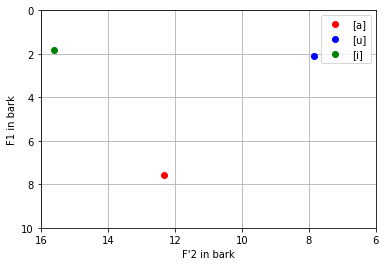

In [10]:
# Synthesizer without noise to be used
synthesizer = Synthesizer(0, 0);

# Bark operator configured as used in paper
bark_operator = BarkOperator(3.5, 0.3);

# Make utterances
phoneme_a = Phoneme(0, 0, 0);
utterance_a = synthesizer.synthesise(phoneme_a);
f1_a = bark_operator.bark_f1(utterance_a);
f2_a = bark_operator.bark_f2(utterance_a);

phoneme_u = Phoneme(1, 1, 1);
utterance_u = synthesizer.synthesise(phoneme_u);
f1_u = bark_operator.bark_f1(utterance_u);
f2_u = bark_operator.bark_f2(utterance_u);

phoneme_i = Phoneme(0, 1, 0);
utterance_i = synthesizer.synthesise(phoneme_i);
f1_i = bark_operator.bark_f1(utterance_i);
f2_i = bark_operator.bark_f2(utterance_i);

# Plot results
plt.plot(f2_a, f1_a, 'ro');
plt.plot(f2_u, f1_u, 'bo');
plt.plot(f2_i, f1_i, 'go');

plt.ylim(0, 10);
plt.xlim(6, 16);

plt.xlabel("F'2 in bark");
plt.ylabel("F1 in bark");
plt.gca().invert_xaxis();
plt.gca().invert_yaxis();
plt.grid();

plt.legend(["[a]", "[u]", "[i]"]);

These findings are not identical to figures such as the one shown [here](https://upload.wikimedia.org/wikipedia/commons/6/6f/F1_and_F2_formant_chart_with_Bark_scale_%282%29.gif).
We test in the following code block the alternative bark conversion to see if that is the cause of this issue.

![](https://upload.wikimedia.org/wikipedia/commons/6/6f/F1_and_F2_formant_chart_with_Bark_scale_%282%29.gif)

300 Hz is 3.0288495575221237 bark.
3.0288495575221237 bark is 299.99999999999994 Hz.
---------------------------------------
600 Hz is 5.753593749999999 bark.
5.753593749999999 bark is 599.9999999999999 Hz.
---------------------------------------
900 Hz is 7.906713286713287 bark.
7.906713286713287 bark is 900.0 Hz.
---------------------------------------
1200 Hz is 9.651012658227849 bark.
9.651012658227849 bark is 1200.0 Hz.
---------------------------------------
2000 Hz is 13.01040404040404 bark.
13.01040404040404 bark is 1999.9999999999995 Hz.
---------------------------------------


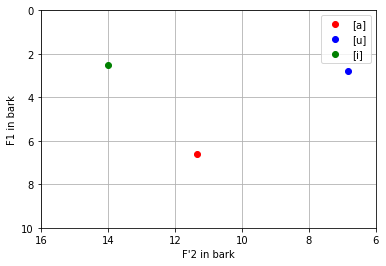

In [11]:
# Synthesizer without noise to be used
synthesizer = Synthesizer(0, 0);

# Bark operator configured as used in paper
bark_operator = BarkOperator(3.5, 0.3, True);

# Test conversions
test_values = [300, 600, 900, 1200, 2000];

for test_value in test_values:
    test_freq = test_value;
    test_bark = bark_operator.hertz_to_bark(test_freq);
    print(f"{test_freq} Hz is {test_bark} bark.");
    
    test_freq_found = bark_operator.bark_to_hertz(test_bark);
    print(f"{test_bark} bark is {test_freq_found} Hz.");
    
    print("---------------------------------------")

# Make utterances
phoneme_a = Phoneme(0, 0, 0);
utterance_a = synthesizer.synthesise(phoneme_a);
f1_a = bark_operator.bark_f1(utterance_a);
f2_a = bark_operator.bark_f2(utterance_a);

phoneme_u = Phoneme(1, 1, 1);
utterance_u = synthesizer.synthesise(phoneme_u);
f1_u = bark_operator.bark_f1(utterance_u);
f2_u = bark_operator.bark_f2(utterance_u);

phoneme_i = Phoneme(0, 1, 0);
utterance_i = synthesizer.synthesise(phoneme_i);
f1_i = bark_operator.bark_f1(utterance_i);
f2_i = bark_operator.bark_f2(utterance_i);

# Plot results
plt.plot(f2_a, f1_a, 'ro');
plt.plot(f2_u, f1_u, 'bo');
plt.plot(f2_i, f1_i, 'go');

plt.ylim(0, 10);
plt.xlim(6, 16);

plt.xlabel("F'2 in bark");
plt.ylabel("F1 in bark");
plt.gca().invert_xaxis();
plt.gca().invert_yaxis();
plt.grid();

plt.legend(["[a]", "[u]", "[i]"]);

There is now more comparison to the previous figure from [here](https://upload.wikimedia.org/wikipedia/commons/6/6f/F1_and_F2_formant_chart_with_Bark_scale_%282%29.gif).
We see that the alternative bark conversion does indeed influence the results.
However, both variants seem suiting enough for the project.

![](https://upload.wikimedia.org/wikipedia/commons/6/6f/F1_and_F2_formant_chart_with_Bark_scale_%282%29.gif)


We now test the distance measure.

In [12]:
# Synthesizer without noise to be used
synthesizer = Synthesizer(0, 0);

# Bark operator configured as used in paper
bark_operator = BarkOperator(3.5, 0.3);

# Make utterances
phoneme_a = Phoneme(0, 0, 0);
utterance_a = synthesizer.synthesise(phoneme_a);

phoneme_u = Phoneme(1, 1, 1);
utterance_u = synthesizer.synthesise(phoneme_u);

phoneme_i = Phoneme(0, 1, 0);
utterance_i = synthesizer.synthesise(phoneme_i);

# Show some distances
print(f"Distance between [a] and [a]: {bark_operator.distance_between_utterances(utterance_a, utterance_a)}");
print();
print(f"Distance between [a] and [u]: {bark_operator.distance_between_utterances(utterance_a, utterance_u)}");
print(f"Distance between [u] and [a]: {bark_operator.distance_between_utterances(utterance_u, utterance_a)}");
print();
print(f"Distance between [a] and [i]: {bark_operator.distance_between_utterances(utterance_a, utterance_i)}");
print(f"Distance between [i] and [a]: {bark_operator.distance_between_utterances(utterance_i, utterance_a)}");
print();
print(f"Distance between [u] and [i]: {bark_operator.distance_between_utterances(utterance_u, utterance_i)}");
print(f"Distance between [i] and [u]: {bark_operator.distance_between_utterances(utterance_i, utterance_u)}");

Distance between [a] and [a]: 0.0

Distance between [a] and [u]: 6.00337920927803
Distance between [u] and [a]: 6.00337920927803

Distance between [a] and [i]: 6.03065439222427
Distance between [i] and [a]: 6.03065439222427

Distance between [u] and [i]: 4.270566850184127
Distance between [i] and [u]: 4.270566850184127


The results we find seem reasonable. We Think this means our bark operations are correct.